# Machine Learning with PyTorch

## Tasks with Networks

<font size="+1">A simple feature classifier</font>
<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">An image classifier</font>
<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">A regression prediction</font>
<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Clustering with PyTorch</font>
<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1"><u><b>Generative Adversarial Networks (GAN)</b></u></font> 
<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Part of Speech Tagger</font>
<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="right"/></a>

## Generative Adversarial Networks

A GAN (Generative Adversarial Network) is a recent and powerful idea in design of neural networks.  While a GAN is technically a form of unsupervised learning, it cleverly captures much of the power of supervised learning models.  These models seem to have been used most widely in image generation contexts, but there is no reason they cannot be applied equally to other domains.  When applied to images, GAN's often produce "surreal" and sometimes disturbing resemblances to real images.

For example, artist and A.I. enthusiast Robbie Barrat has produced these [images derived from painted nudes](https://twitter.com/DrBeef_/status/978732422085988352/photo/1?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E978732422085988352&ref_url=https%3A%2F%2Fwww.zmescience.com%2Fscience%2Fai-nudes-surreal-185131341%2F):

![GAN Nudes](img/GAN-nudes.png)

Or mentioned in this Martin Giles article in [MIT Technology Review](https://www.technologyreview.com/s/610253/the-ganfather-the-man-whos-given-machines-the-gift-of-imagination/) are these authentic seeming images of "fake celebrities" (computer generated images trained from many images of actual celebrities):

![GAN celebs](img/GAN-celebs.png)

The basic idea in a GAN is to run *two* neural networks in competition—hence the "adversarial" part of the name.  

One neural network is a "generator." Its goal is to generate new data that cannot be distinguished from genuine samples used to develop the GAN.  I.e. we **do** need to start with training datasets, but we do not have any known target feature that identifies correctness.  This is an unsupervised network, but correctness is defined by "belonging to the training set" as opposed to being any other (distribution of) possible values for the features.

The other neural network is the "discriminator." Its goal is to distinguish synthetic samples or observations from genuine ones.  The discriminator engages in a kind of supervised learning, since we the developers *do know* which image is which and can provide feedback to the discriminator.  While supervised models are very powerful, real world data is rarely trying actively to fool them about the class a datum belongs to.  In the GAN model, the adversary is specifically trying to outwit the classifier.

Of course, there are some cases in the real world where fake data tries actively to pass itself off.  In forgery or fraud, a malicious actor is trying to create currency, or artwork, or some other item that can pass inspection by (human or machine) discriminators.  And many kinds of fraud involve trying to create transactions or messages that are difficult to distinguish from legitimate ones.  Unfortunately, GANs will probably be—in fact, probably already are—used to aid in some such fraud.

This O'Reilly Press illustration is a good summary:

![GAN schema](img/gan_schema.png)

### A toy example

For our sample code, we borrow and minimally change a GAN written by Dev Nag in his blog post [Generative Adversarial Networks (GANs) in 50 lines of code (PyTorch)](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f).  Given that it is a toy, designed for simplicity of presentation, all this GAN is trying to learn is a Gaussian random distribution.

In [1]:
from datetime import datetime
from time import time
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
import torch
import torch.nn as nn
import torch.optim as optim
from torch import sigmoid, tanh, relu
%matplotlib inline

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    torch.cuda.memory_allocated()
    # *MUCH* faster to run on GPU
    device = torch.device('cuda') 
    
print(device)

cuda


### Create the dataset

First thing, initialize the dataset in our mentioned random distribution.  We have a number of choices about what "features" of the data we wish to model.  For this example, we use simply the first four moments of the data, but we could easily use the raw points, or other abstractions of the "shape" of the data, as we wished.

```python
def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - mean_broadcast, exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)
    
# Unused data features (experiment with these on your own).
# Raw data
preprocess, get_num_features = lambda data: data, lambda x: x
# Data and variances
preprocess, get_num_features = lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2
# Data and diffs
preprocess, get_num_features = lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2
```

In [2]:
def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    # excess kurtosis, should be 0 for Gaussian
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  
    final = torch.cat((mean.reshape(1,), std.reshape(1,), 
                       skews.reshape(1,), kurtoses.reshape(1,)))
    return final

# Data points
def d_sampler(n=500, mu=4, sigma=1.25):
    "Provide `n` random Gaussian distributed points with mean `mu` and std `sigma`"
    return torch.Tensor(np.random.normal(mu, sigma, n)).to(device)

def gi_sampler(m=500, n=1):
    "Uniform-dist data into generator, NOT Gaussian"
    return torch.rand(m, n).to(device)

preprocess = get_moments

#### Utility functions

In [3]:
def extract(v):
    return v.data.storage().tolist() 

def stats(v):
    d = extract(v)
    return (np.mean(d), np.std(d), skew(d), kurtosis(d))

#### Visualize a sample from the target distribution

Let us quickly remind ourselves of what we are trying to imitate with the GAN.  This is a sample, and it will look slightly different each time we pull from distribution.  Notice in particular what the mean and spread are, which have to be learned.  For the couple histograms below, we pull 5000 points each from the target distribution and noise distribution to show the underlying "shape" more clearly.  In our actual GAN presented here, we use samples of 500 points from the same distribution, which looks a lot more "stochastic" in its picture, but is a good proxy for something like a photographic image of limited resolution, which are often the inputs to GANs.

Mean: 3.99 | Std: 1.27 | Skew: -0.00 | Kurt: -0.099000
CPU times: user 1.13 s, sys: 544 ms, total: 1.67 s
Wall time: 1.68 s


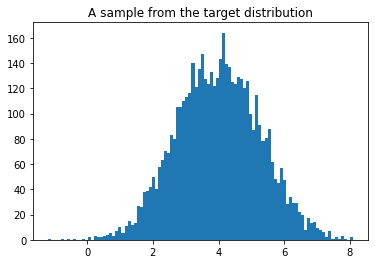

In [4]:
%%time
v = d_sampler(5000)
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
_ = plt.title("A sample from the target distribution")

Mean: 4.00 | Std: 1.25 | Skew: -0.01 | Kurt: -0.165546
CPU times: user 56.4 ms, sys: 4.56 ms, total: 61 ms
Wall time: 59.8 ms


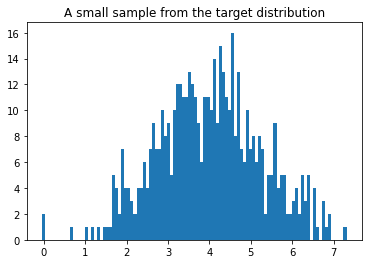

In [5]:
%%time
v = d_sampler()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
_ = plt.title("A small sample from the target distribution")

Mean: 0.50 | Std: 0.29 | Skew: 0.01 | Kurt: -1.219192


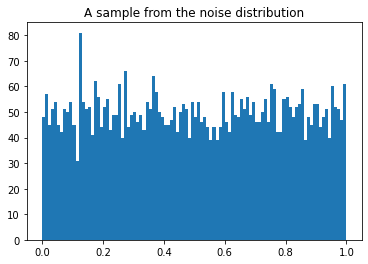

In [6]:
v = gi_sampler(5000).flatten()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
plt.title("A sample from the noise distribution");

Mean: 0.49 | Std: 0.29 | Skew: -0.01 | Kurt: -1.237285


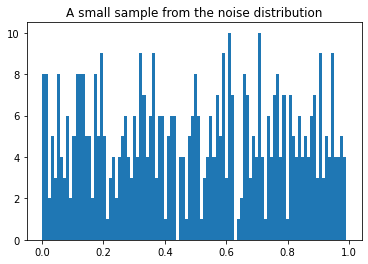

In [7]:
v = gi_sampler().flatten()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
plt.title("A small sample from the noise distribution");

### Define the Models

Define a generator and a discriminator in a standard fashion for PyTorch models.  Both have 3 linear layers.

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super().__init__()
        self.dropout = nn.Dropout(0.25)
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.dropout(x)  # Can we avoid a local trap?
        x = self.f(x)
        x = self.map2(x)
        x = self.dropout(x)  # Can we avoid a local trap?
        x = self.f(x)
        x = self.map3(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super().__init__()
        self.dropout = nn.Dropout(0.25)
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        # dropout layers might make discriminator more robust
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        x = self.f(x)
        return x

### Instantiate models, loss, and optimizer

In [10]:
# Model parameters
G = Generator(input_size=1,   # Random noise dimension, per output vector
              hidden_size=10, # Generator complexity
              output_size=1,  # Size of generated output vector
              f=relu          # Activation function
             ).to(device)

# Use input_size = get_num_features(...) if you try other examples
D = Discriminator(input_size=4,   # 4 moments/features
                  hidden_size=10, # Discriminator complexity
                  output_size=1,  # Single dimension for 'real' vs. 'fake' classification
                  f=sigmoid       # Activation function
                 ).to(device)

# Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
criterion = nn.BCELoss()  

# Stochastic Gradient Descent optimizers
d_learning_rate = 2e-4
g_learning_rate = 2e-4
sgd_momentum = 0.9
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

### Train the model

During training we will show some information and visualization of the progress.

In [11]:
def train(minibatch_size: int=500, 
          g_input_size: int=1, 
          d_input_size: int=5001,
          g_steps: int=20,
          d_steps: int=20,
          num_epochs: int=5001,
          print_interval: int=500,
          fname="img/GAN-%s.png" % datetime.now().isoformat()):

    start = time() 
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = d_sampler(d_input_size)
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, torch.ones([1]).to(device))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = gi_sampler(minibatch_size, g_input_size)
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, torch.zeros([1]).to(device))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; 
                                   # changes based on stored gradients from backward()

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = gi_sampler(minibatch_size, g_input_size)
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            # Train G to pretend it's genuine
            g_error = criterion(dg_fake_decision, torch.ones([1]).to(device))

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

        if epoch % print_interval == 0:
            rstats, fstats = stats(d_real_data), stats(d_fake_data)
            print("Epoch", epoch, "\n",
                  "Real Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f\n" % tuple(rstats),
                  "Fake Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f\n" % tuple(fstats),
                  "Time elapsed: %.2f seconds" % (time() - start))
            start = time()
            
            values = extract(g_fake_data)
            plt.hist(values, bins=100)
            plt.xlabel('Value')
            plt.ylabel('Count')
            plt.title('Histogram of Generated Distribution (epoch %d)' % epoch)
            plt.grid(True)
            plt.show()
    
    plt.savefig(fname)

Epoch 0 
 Real Dist: Mean: 3.99, Std: 1.26, Skew: 0.00, Kurt: 0.101640
 Fake Dist: Mean: -0.25, Std: 0.11, Skew: 0.44, Kurt: -0.732305
 Time elapsed: 0.65 seconds


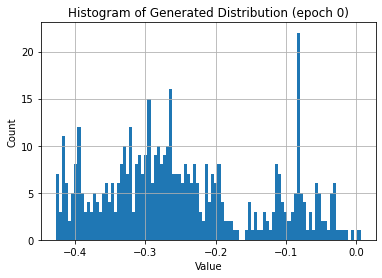

In [ ]:
train()

### Pitfalls and guidelines

When you train the discriminator, the generator will remain contant, and vice versa.  This gives each model a static adversary. If you have a roughly known domain, you might wish to pretrain the discriminator on similar data before starting your training of the generator.  This gives the generator a more difficult adversary to work against.

Depending on the details of the network you configue, as well as other options in their training regimes, learning rates, optimizers, loss functions, and so on, one side of the GAN can overpower the other. If the discriminator is too good, it will return values  close to 0 or 1, and that the generator will be unable to find a meaningful gradient. If the generator is too good, it will exploit weaknesses in the discriminator that lead to false negatives. 

---

Dev Nag, in his blog post that I base this lesson on, present results from multiple runs of and identical GAN, mostly the same at the one in this notebook.  At times it does quite well, but at other times—just depending on randomized initial conditions—it does extremely poorly.  Sometimes additional training rounds may force them out of a poor local maximum, but often an unbalance is reached where progress is not possible.  I am *curious*, and explore it passingly above, whether addition of dropout layers or other layer engineering might mitigate this danger.

![GAN generated distributions](img/GAN-generated-distributions.png)

This final part will run for a long time.  But let us try to replicate successful and failing GANs over a large number epochs, with a large number of trials.

In [ ]:
d_learning_rate = 2e-4
g_learning_rate = 2e-4

for _ in range(100):
    # Generate 100 final images
    torch.cuda.empty_cache() 
    
    # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    criterion = nn.BCELoss()  

    # Experiment: try different (decreasing) learning rates
    d_learning_rate *= 0.96
    g_learning_rate *= 0.96
    
    # Stochastic Gradient Descent optimizers
    sgd_momentum = 0.9
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)    
    
    # Reinitialize generator
    G = Generator(input_size=1,   # Random noise dimension, per output vector
                  hidden_size=10, # Generator complexity
                  output_size=1,  # Size of generated output vector
                  f=relu          # Activation function
                 ).to(device)

    # Reinitialize discriminator
    D = Discriminator(input_size=4,   # 4 moments/features
                      hidden_size=10, # Discriminator complexity
                      output_size=1,  # Single dimension for 'real' vs. 'fake' classification
                      f=sigmoid       # Activation function
                     ).to(device)

    # 10x the default training rounds
    num_epochs = 20_000
    fname = "img/GAN-dlr_%0.4f_glr_%0.4f_epochs_%d.png" % (
                d_learning_rate, g_learning_rate, num_epochs)
    train(num_epochs=num_epochs, 
          print_interval=num_epochs//2, 
          fname=fname)

## Next Lesson

**Tasks with Networks**: This lesson examined Generative Adversarial Networks. The next lesson will create a part-of-speech tagger.

<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="left"/></a>